In [1]:
!pip install gym==0.25.2

In [2]:
!pip install swig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.8 MB/s eta 0:00:00


In [3]:
!pip install gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 36.1 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376133 sha256=96ae9c1dc3f2f01d041b600c4468be9c04e29b002d23073c7c972fabb6df7218
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [4]:
import gym
import torch

from collections import deque
import random

import copy
from torch.autograd import Variable
import numpy as np
import time
import json
import os
from datetime import datetime
import psutil
import os
import matplotlib.pyplot as plt

In [5]:
# Get current process ID
pid = os.getpid()
process = psutil.Process(pid)
env = gym.envs.make("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:
class DQN():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.05, device='cpu'):
        self.criterion = torch.nn.MSELoss()
        self.device = device
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(n_state, n_hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(n_hidden, n_hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(n_hidden, n_hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(n_hidden, n_action)
                )


        self.model_target = copy.deepcopy(self.model)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def update(self, s, y):
        """
        Update the weights of the DQN given a training sample
        @param s: state
        @param y: target value
        """
        s = np.array(s)
        y_pred = self.model(torch.Tensor(s))

        loss = self.criterion(y_pred, Variable(torch.Tensor(np.array(y))))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, s):
        """
        Compute the Q values of the state for all actions using the learning model
        @param s: input state
        @return: Q values of the state for all actions
        """
        with torch.no_grad():
            return self.model(torch.Tensor(np.array(s)))

    def target_predict(self, s):
        """
        Compute the Q values of the state for all actions using the target network
        @param s: input state
        @return: targeted Q values of the state for all actions
        """
        with torch.no_grad():
            return self.model_target(torch.Tensor(np.array(s)))

    def replay(self, memory, replay_size, gamma):
        """
        Experience replay with target network
        @param memory: a list of experience
        @param replay_size: the number of samples we use to update the model each time
        @param gamma: the discount factor
        """
        if len(memory) >= replay_size:
            replay_data = random.sample(memory, replay_size)

            states = []
            td_targets = []
            for state, action, next_state, reward, is_done in replay_data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if is_done:
                    q_values[action] = reward
                else:
                    q_values_next = self.target_predict(next_state).detach()

                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                td_targets.append(q_values)

            self.update(states, td_targets)

    def copy_target(self):
        self.model_target.load_state_dict(self.model.state_dict())

    def name(self):
      return "Model C"

    def save_model(self, file_path):
        torch.save(self.model.state_dict(), file_path)

    def load_model(self, file_path):
        self.model.load_state_dict(torch.load(file_path, map_location=self.device))
        self.model_target = copy.deepcopy(self.model)



In [7]:
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
        if random.random() < epsilon:
            return random.randint(0, n_action - 1)
        else:
            q_values = estimator.predict(state)
            return torch.argmax(q_values).item()
    return policy_function

In [8]:

n_episode = 1000
replay_size = 142
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 62
target_update = 10
replay_size = 142
lr = 0.001
epsilon = 0.1
gamma = 1.0
dqn = DQN(n_state,n_action,n_hidden,lr)
memory = deque(maxlen=10000)
epsilon_decay = 0.99

In [9]:
import os

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
PATH= '/content/drive/MyDrive/Colab Notebooks/Python_Course/PyTorch_Course/rl/DDQN/Models'

In [11]:
os.chdir(PATH)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
model_path = "double_dqn_lunar_lander.pth"
if os.path.exists(model_path):
    dqn.load_model(model_path)
    print("Loaded existing model.")
else:
    print("No existing model found. Starting training from scratch.")

Loaded existing model.


In [14]:
total_reward_episode = [0] * n_episode

In [15]:

for episode in range(n_episode):
    # print(f"Episode: {episode}")
    if episode % target_update == 0:
        dqn.copy_target()
    policy = gen_epsilon_greedy_policy(dqn,epsilon,n_action)
    state = env.reset()
    is_done = False

    while not is_done:
        # print(f"State: {state}")
        action = policy(state)
        next_state,reward,is_done,_ = env.step(action)
        total_reward_episode[episode] += reward
        memory.append((state,action,next_state,reward,is_done))

        if is_done:
            break

        dqn.replay(memory,replay_size,gamma)
        state = next_state
    print(f"Episode: {episode} Reward: {total_reward_episode[episode]}")
    epsilon = max(epsilon*epsilon_decay,0.01)
    # Save the model every 50 episodes
    if (episode + 1) % 50 == 0:
        dqn.save_model(model_path)
        print(f"Model saved after episode {episode + 1}")



/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0 Reward: -99.23476875246897
Episode: 1 Reward: 33.9104877721021
Episode: 2 Reward: -121.16710466434618
Episode: 3 Reward: -117.39568332343187
Episode: 4 Reward: -4.85116828388142
Episode: 5 Reward: -12.429224981165945
Episode: 6 Reward: -39.421016105478614
Episode: 7 Reward: -352.438847166321
Episode: 8 Reward: -55.06044832363042
Episode: 9 Reward: -244.70563888958176
Episode: 10 Reward: -34.919977611277176
Episode: 11 Reward: 201.79940627052304
Episode: 12 Reward: -58.33182423683045
Episode: 13 Reward: -33.00376757562111
Episode: 14 Reward: -79.83803039629106
Episode: 15 Reward: -93.36749120532704
Episode: 16 Reward: -145.82527158170717
Episode: 17 Reward: -84.53505616283898
Episode: 18 Reward: -37.273049917370756
Episode: 19 Reward: -18.056464605592794
Episode: 20 Reward: -77.21900293709152
Episode: 21 Reward: -18.960794767415578
Episode: 22 Reward: -46.12388104417059
Episode: 23 Reward: -110.75803598407362
Episode: 24 Reward: -104.56391212643831
Episode: 25 Reward: -128.84

KeyboardInterrupt: 

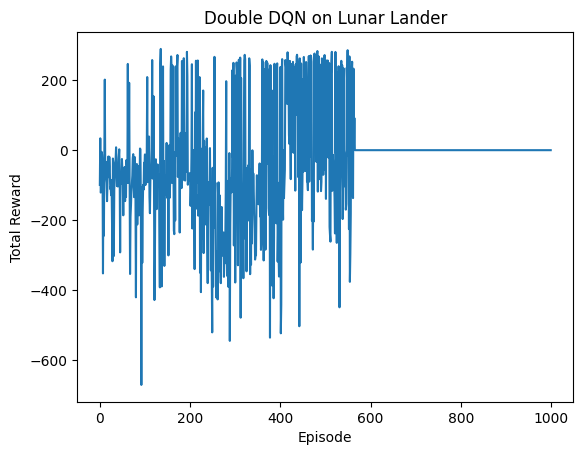

In [16]:
# Plot the rewards
plt.plot(total_reward_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Double DQN on Lunar Lander')
plt.show()